In [43]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import thermal_evolution_layers as th
from imp import reload
import solubility_library as sol
reload(th)
reload(sol)
import scipy.special as sp

In [44]:
pl = th.Planet_Custom()

In [50]:
times = np.linspace(0,4568e6*365.25*24*3600,5000)
T_cmb0 = 5900
T_um0 = 3150
# T_cmb0 = 5400
# T_um0 = 2550


x0 = [T_cmb0, T_um0]
# initial core state
wtp_Mg = 0.01
wtp_Si = 0.000001
wtp_O = 0.12
wtp_Fe = 1-wtp_Mg-wtp_Si-wtp_O
wtp_i_c_0 = np.array([wtp_Mg, wtp_Si, wtp_Fe, wtp_O])
mass_c = 1.95e24 #kg
M_i_c_0 = list(pl.reactions.wtp_i_c_2_M_i_c(wtp_i_c_0, mass_c))
M_c_0 = np.sum(M_i_c_0)
M_i_c_0.append(M_c_0)

# initial mantle state
MgFe_ratio = 0.8
X_MgO_0 = 0.05*MgFe_ratio
X_SiO2_0 = 0.005
X_FeO_0 = 0.05*(1-MgFe_ratio)
X_MgSiO3_0 = (1-X_MgO_0+X_SiO2_0+X_FeO_0)*(X_MgO_0/(X_MgO_0+X_FeO_0))
X_FeSiO3_0 = (1-X_MgO_0+X_SiO2_0+X_FeO_0)*(X_FeO_0/(X_MgO_0+X_FeO_0))
X_i_m_0 = np.array([X_MgO_0, X_SiO2_0, X_FeO_0, X_MgSiO3_0, X_FeSiO3_0])
M_i_m_0 = pl.reactions.X2M_m(X_i_m_0)
Moles_0 = M_i_c_0+M_i_m_0

pl.params.reactions.Moles_0 = Moles_0

x0 = x0+Moles_0

nu_present = 10**21/pl.params.mantle.rho #[m^2/s]
T_present = 1350 # [K]
nu_old =  nu_present/1e3
T_old = T_um0
A,nu0 = pl.mantle_layer.find_arrenhius_params(nu_present, T_present, nu_old, T_old)
print(A,nu0)
pl.params.mantle.A = A
pl.params.mantle.nu_0 = nu0
# pl.params.mantle.A = 2e4
# pl.params.mantle.nu_0 = 1.5e11

solution = pl.integrate(times, x0)

16319.5718466 1.12468265038e+12


In [51]:
X_MgSiO3_0

0.7800000000000001

In [52]:
X_FeSiO3_0

0.19499999999999995

1778.81310971


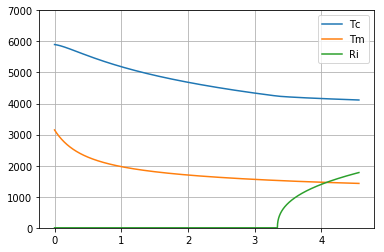

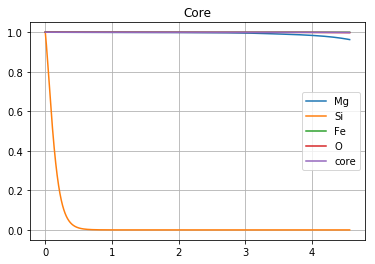

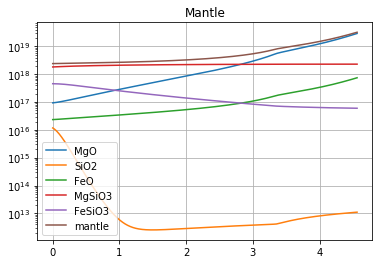

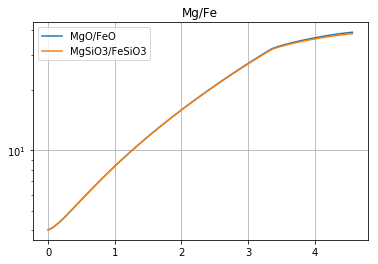

In [53]:
N = len(times)
T_cmb = solution[:N,0]
T_um = solution[:N,1]

t_plt = times[:N]/3.16e7/1e9

r_i = np.array([pl.core_layer.r_i(x, recompute=True) for x in T_cmb])

plt.plot(t_plt, T_cmb, label='Tc')
plt.plot(t_plt, T_um, label='Tm')
plt.plot(t_plt, r_i/1e3, label='Ri')
plt.ylim(0,7000)
plt.legend(loc=0)
plt.grid()

plt.figure()
plt.title('Core')
for i in range(5):
    M = solution[:N,2+i]/solution[0,2+i]
    plt.plot(t_plt, M, label=pl.params.reactions.species_names[i])
plt.legend(loc=0)
# plt.ylim(0.9999,1.0001)
plt.grid()

plt.figure()
plt.title('Mantle')
for i in range(5,11):
#     M = solution[:N,2+i]/solution[0,2+i]
    M = solution[:N,2+i]
    plt.semilogy(t_plt, M, label=pl.params.reactions.species_names[i])
plt.legend(loc=0)
plt.grid()

plt.figure()
plt.title('Mg/Fe')
M = solution[:N,2+5]/solution[:,2+7]
plt.semilogy(t_plt, M, label=pl.params.reactions.species_names[5]+'/'+pl.params.reactions.species_names[7])
M = solution[:N,2+8]/solution[:,2+9]
plt.semilogy(t_plt, M, label=pl.params.reactions.species_names[8]+'/'+pl.params.reactions.species_names[9])
plt.legend(loc=0)
plt.grid()

# plt.figure()
# plt.title('Fe')
# M = solution[:N,2+5]/solution[:,2+7]
# plt.semilogy(t_plt, M, label=pl.params.reactions.species_names[5]+'/'+pl.params.reactions.species_names[7])
# M = solution[:N,2+8]/solution[:,2+9]
# plt.semilogy(t_plt, M, label=pl.params.reactions.species_names[8]+'/'+pl.params.reactions.species_names[9])
# plt.legend(loc=0)
# plt.grid()

print(r_i[-1]/1e3)

In [12]:
Ts = np.linspace(2000,6000,200)

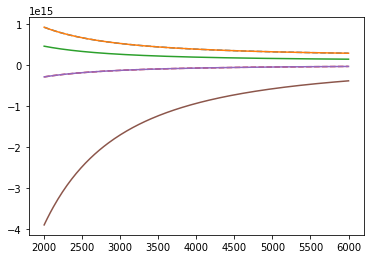

In [13]:
out = np.zeros((len(Ts),len(Moles_0)))
dM_m = np.zeros((len(Ts)))
dM_c = np.zeros((len(Ts)))
for i,T in enumerate(Ts):
    dKs = pl.reactions.compute_dKs_dT(T_cmb=T, Moles=Moles_0)
    out[i,:] = pl.reactions.dMoles_dT(Moles=Moles_0, T_cmb=T)
    dM_m[i] = pl.reactions.dM_m_dTc(Moles_0, dKs)
    dM_c[i] = pl.reactions.dM_c_dTc(Moles_0, dKs)
    
# plt.plot(Ts, dM_m)
plt.plot(Ts, dM_c,'--')
plt.plot(Ts, out[:,4],'-')
plt.plot(Ts, np.sum(out[:,:3],axis=1))
plt.plot(Ts, dM_m,'--')
plt.plot(Ts, out[:,-1],'-')
plt.plot(Ts, np.sum(out[:,6:-2],axis=1))

(-2000000000000000.0, 2000000000000000.0)

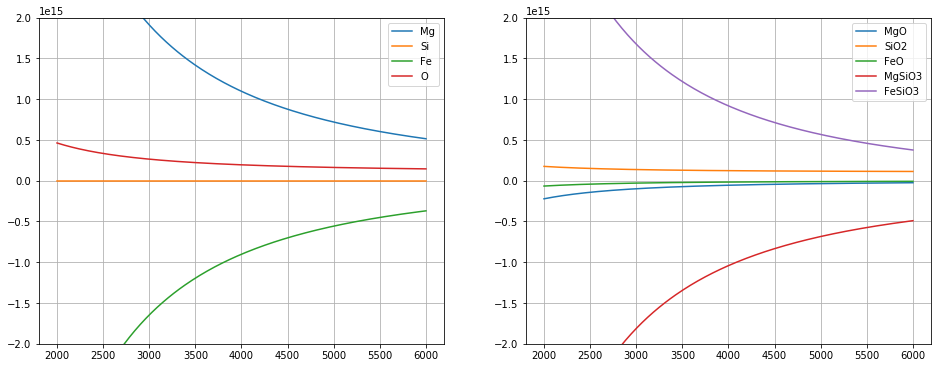

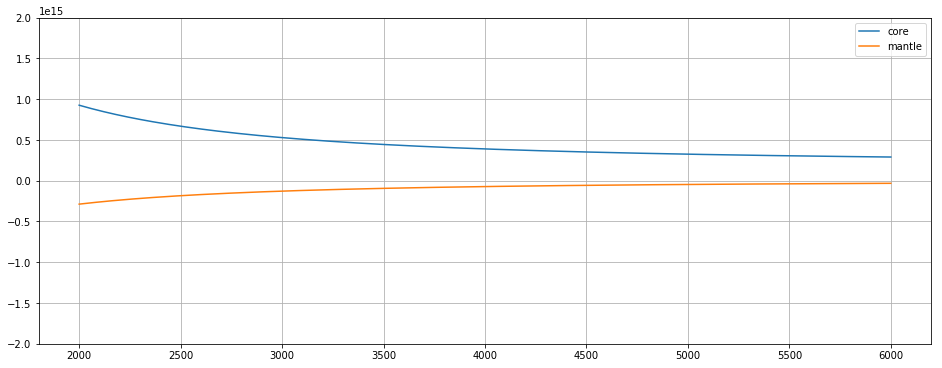

In [14]:
out = np.zeros((len(Ts),len(Moles_0)))
for i,T in enumerate(Ts):
    out[i,:] = pl.reactions.dMoles_dT(Moles=Moles_0, T_cmb=T)
# pl.reactions.unwrap_Moles()
plt.figure(figsize=(16,6))
plt.subplot(121)

for i in range(4):
    sp = pl.params.reactions.species_names[i]
    plt.plot(Ts,out[:,i], label=sp)
plt.legend()
plt.grid()
plt.ylim(-2e15,2e15)

plt.subplot(122)
for i in range(5,10):
    sp = pl.params.reactions.species_names[i]
    plt.plot(Ts,out[:,i], label=sp)
plt.legend()
plt.grid()
plt.ylim(-2e15,2e15)

plt.figure(figsize=(16,6))
for i in [4,-1]:
    sp = pl.params.reactions.species_names[i]
    plt.plot(Ts,out[:,i], label=sp)
plt.legend()
plt.grid()
plt.ylim(-2e15,2e15)

# plt.ylim(-.1e19, .1e19)

(0, 70)

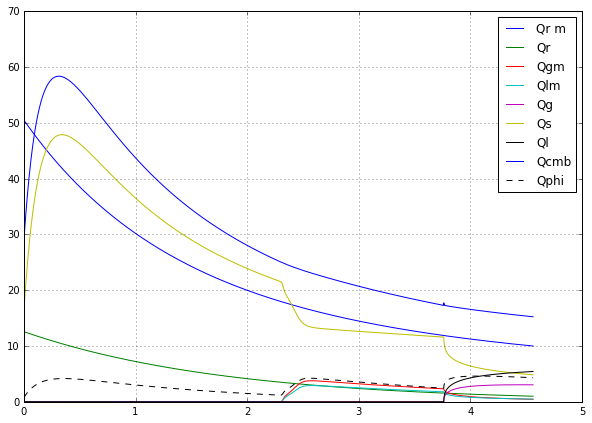

In [18]:
Qrm = pl.mantle_layer.heat_production(times)*pl.mantle_layer.volume
Qrc = pl.core_layer.heat_production_per_kg(times)*pl.core_layer.mass
pc = pl.core_layer.params.core
N = len(times[1:])
Qgm = np.empty(N)
Qtgm = np.empty(N)
QtT = np.empty(N)
Qg = np.empty(N)
Qs = np.empty(N)
Ql = np.empty(N)
Qlm = np.empty(N)
Qk = np.empty(N)
Qcmb = np.empty(N)
Qphi = np.empty(N)
Er = np.empty(N)
Egm = np.empty(N)
Etgm = np.empty(N)
Eg = np.empty(N)
Es = np.empty(N)
El = np.empty(N)
Ek = np.empty(N)
DE = np.empty(N)
Ephi = np.empty(N)
dCex = np.empty(N)
dCer = np.empty(N)
dXmgdT = np.empty(N)
dTcmb = np.diff(T_cmb) / np.diff(times)
qcmb_flux = np.empty(N)
for i, t, T, dT, m, o, c, Tm in zip(range(N), times[1:], T_cmb[1:], dTcmb, XMg[1:],
                                XO[1:], C[1:], T_um[1:]):
    pl.core_layer.reset_current_values()
    Qgm[i] = (pl.core_layer.Q_gm(T, dT, m, o, c, recompute=False))
    Qtgm[i] = (pl.core_layer.Qt_gm(T, m, o, c, recompute=False))
    QtT[i] = (pl.core_layer.Qt_T(T, m, o, c, recompute=False))
    Qg[i] = (pl.core_layer.Q_g(T, dT, recompute=False))
    Qs[i] = (pl.core_layer.Q_s(T, dT, recompute=False))
    Ql[i] = (pl.core_layer.Q_L(T, dT, recompute=False))
    Qlm[i] = (pl.core_layer.Q_Lm(T, dT, m, o, c, recompute=False))
    Qk[i] = (pl.core_layer.Q_k(T, recompute=False))
    h = pl.core_layer.heat_production_per_kg(t)
    Qcmb[i] = (pl.core_layer.Q_cmb(T, dT, h, m, o, c, recompute=False))
    Qphi[i] = (pl.core_layer.Q_phi(T, dT, h, m, o, c, recompute=False))
    Er[i] = (pl.core_layer.E_R(T, h, recompute=False))
    Egm[i] = (pl.core_layer.E_gm(T, dT, m, o, c, recompute=False))
    Etgm[i] = (pl.core_layer.Et_gm(T, m, o, c, recompute=False))
    Eg[i] = (pl.core_layer.E_g(T, dT, recompute=False))
    Es[i] = (pl.core_layer.E_s(T, dT, recompute=False))
    El[i] = (pl.core_layer.E_L(T, dT, recompute=False))
    Ek[i] = (pl.core_layer.E_k(recompute=False))
    DE[i] = (pl.core_layer.Delta_E(T, dT, h, m, o, c, recompute=False))
    Ephi[i] = (pl.core_layer.E_phi(T, dT, h, m, o, c, recompute=False))
    dCex[i] = (pl.MgO_layer.dCdt_exsolve(m, o, c, T, dT))
    dCer[i] = (pl.MgO_layer.dCdt_erode(c))
    qcmb_flux[i] = pl.mantle_layer.lower_boundary_flux(T, Tm)
#     dXmgdT[i] = pl.core_layer.dXmgdT()


Cm = pl.core_layer.C_m(T_cmb, XMg=XMg, XO=XO, C=C, recompute=True)
plt.figure(figsize=(10,7))
plt.plot(t_plt, Qrm/1e12, label='Qr m')
plt.plot(t_plt, Qrc/1e12, label='Qr')
plt.plot(t_plt[1:], Qgm/1e12, label="Qgm")
plt.plot(t_plt[1:], Qlm/1e12, label="Qlm")
plt.plot(t_plt[1:], Qg/1e12, label="Qg")
plt.plot(t_plt[1:], Qs/1e12, label="Qs")
plt.plot(t_plt[1:], Ql/1e12, label="Ql")
# plt.plot(t_plt[1:], Qk/1e12, label="Qk")
plt.plot(t_plt[1:], Qcmb/1e12, label="Qcmb")
plt.plot(t_plt[1:], Qphi/1e12, 'k--', label="Qphi")
plt.legend(loc=0)
plt.grid()
plt.ylim(0,70)

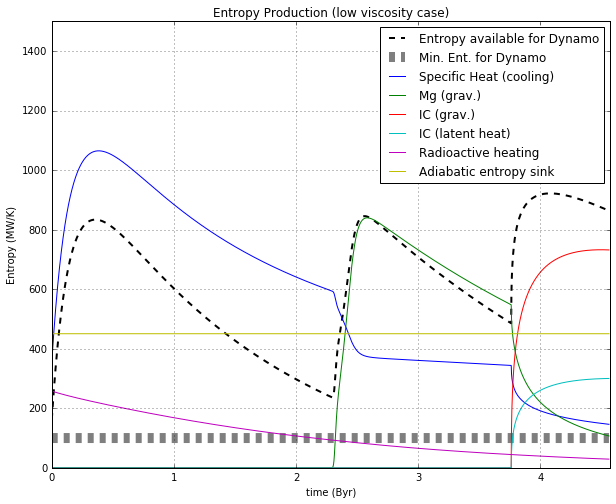

In [19]:
min_E = 100e6 # [MW/K]
plt.figure(figsize=(10,8))
plt.plot(t_plt[1:], Ephi/1e6, '--k', label="Entropy available for Dynamo", linewidth=2.)
plt.plot(t_plt, min_E*np.ones_like(t_plt)/1e6, '--k', label='Min. Ent. for Dynamo', linewidth=10, alpha=0.5)
plt.plot(t_plt[1:], Es/1e6, label="Specific Heat (cooling)")
plt.plot(t_plt[1:], Egm/1e6, label="Mg (grav.)")
plt.plot(t_plt[1:], Eg/1e6, label="IC (grav.)")
plt.plot(t_plt[1:], El/1e6, label="IC (latent heat)")
plt.plot(t_plt[1:], Er/1e6, label='Radioactive heating')
plt.plot(t_plt[1:], Ek/1e6, label="Adiabatic entropy sink")
# plt.plot(t_plt[1:], DE/1e6, label="E tot")
plt.ylim(0,1500)
plt.xlim(0,4.568)
plt.title('Entropy Production (low viscosity case)')
plt.ylabel('Entropy (MW/K)')
plt.xlabel('time (Byr)')
plt.legend(loc=0)
plt.grid()
plt.savefig('S_lowvisc.png')

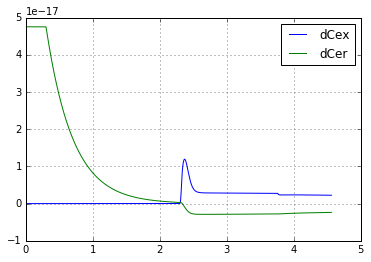

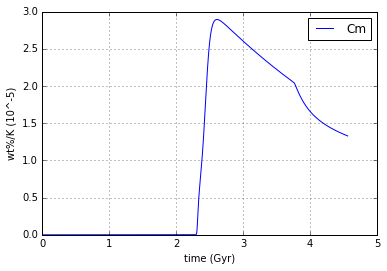

In [20]:
plt.figure()
plt.plot(t_plt[1:], dCex, label='dCex')
plt.plot(t_plt[1:], dCer, label='dCer')
plt.legend(loc=0)
plt.grid()
plt.figure()
plt.plot(t_plt, -Cm*1e5, label='Cm')
plt.ylabel('wt%/K (10^-5)')
plt.xlabel('time (Gyr)')
plt.legend(loc=0)
plt.grid()

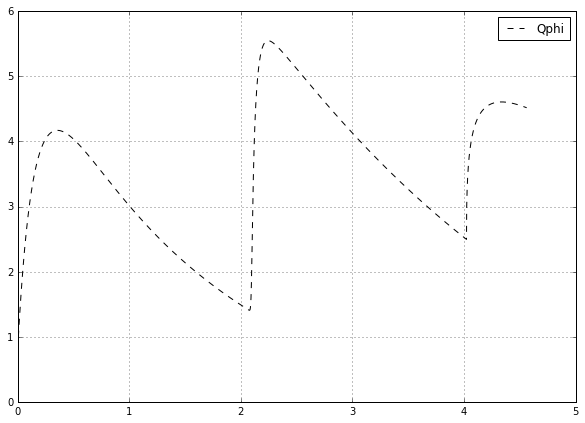

In [11]:
plt.figure(figsize=(10,7))
plt.plot(t_plt[1:], Qphi/1e12, 'k--', label="Qphi")
plt.legend(loc=0)
plt.grid()
# plt.ylim(0,70)